In [52]:
import pandas as pd
import GPy
import matplotlib.pyplot as plt
from jupyterthemes import jtplot
import numpy as np
%pylab inline
import pylab as pb
pylab.ion()
jtplot.style(theme='onedork')

Populating the interactive namespace from numpy and matplotlib


# Unidades de las tablas
<br><br>
## Archivo: 000 Analisis_Produccion-consumos CUAS.xlsx
<br><br>

### Primera tabla:
Esta tabla es de produccion de cobre
* Toneladas de cobre fino producido
<br><br>

### Segunda tabla:
Esta tabla es de produccion de cobre, pero separado por tamaño de la mina:
* Toneladas de cobre fino producido
<br><br>

### Tercera tabla:
Esta tabla es lo que consumimos de acido, considerando lo producido más lo importado (uno en cada fila):
* Toneladas de acido

## Archivo: 000 Analisis_Produccion-consumos CUAS.xlsx


In [2]:
# cargar Hoja1 del archivo: 000 Analisis _ Produccion-consumos CUAS.xlsx
# para crear los dataframes con produccion de fino y consumo de acido en
# indexados por el tiempo

folder = '/Users/juanpablodonosomerlet/Desktop/estudio-acidos/data/'
xls = pd.ExcelFile(folder + '000 Analisis _ Produccion-consumos CUAS.xlsx')
df1 = pd.read_excel(xls, 'Hoja1')
nombres_df1 = list(df1.columns.values)

In [53]:
# funcion para plotear multi-task GP (Ricardo Andrade-Pacheco)
def plot_2outputs(m,xlim,ylim):
    fig = pb.figure(figsize=(12,8))
    #Output 1
    ax1 = fig.add_subplot(211)
    ax1.set_xlim(xlim)
    ax1.set_title('Output 1')
    m.plot(plot_limits=xlim,fixed_inputs=[(1,0)],which_data_rows=slice(0,100),ax=ax1)
    ax1.plot(Xt1[:,:1],Yt1,'rx',mew=1.5)
    #Output 2
    ax2 = fig.add_subplot(212)
    ax2.set_xlim(xlim)
    ax2.set_title('Output 2')
    m.plot(plot_limits=xlim,fixed_inputs=[(1,1)],which_data_rows=slice(100,200),ax=ax2)
    ax2.plot(Xt2[:,:1],Yt2,'rx',mew=1.5)

In [36]:
# tabla1: produccion de fino, toda la informacion
tabla1 = df1.loc[:7,nombres_df1[2:18]]
tabla1 = tabla1.dropna()
tabla1.iloc[0].apply(int)
años = tabla1.iloc[0].apply(int)
dicc_years = {}
for i,year in enumerate(años):
    dicc_years[nombres_df1[2:18][i]] = year
tabla1 = tabla1.rename(dicc_years, axis='columns').loc[1:,:]
tabla1 = tabla1.append(tabla1.sum(), ignore_index=True)

# tabla2: consumo de acido
tabla2 = df1.loc[60:,nombres_df1[2:24]]
años2= tabla2.iloc[0].apply(int)
dicc_years2 = {}
for i,year in enumerate(años2):
    dicc_years2[nombres_df1[2:24][i]] = year
tabla2 = tabla2.rename(dicc_years2, axis='columns').loc[61:,:]

# tabla2: Leyes promedio de cobre anuales
xls_leyes = pd.ExcelFile(folder + 'Leyes Cu.xlsx')
hoja_leyes = xls_leyes.sheet_names[0]
df_leyes = pd.read_csv(folder+'leyes.csv')
# xls_leyes.sheet_names[3]

In [7]:
# dataframe de la produccion anual de fino 
produccion_fino = pd.DataFrame(tabla1.loc[6,:], index=list(tabla1.columns.values))
produccion_fino = produccion_fino.rename({6:'Produccion Cu fino anual'}, axis='columns')
produccion_fino

# dataFrame del consumo total de acido
consumo_acido = tabla2.transpose()
consumo_acido = consumo_acido.rename({61:'Produccion',
                                      62:'Importaciones',63:'Total'}, axis='columns')
produccion_fino
# print(consumo_acido.astype(int))
# consumo_acido.astype(int)

,Produccion Cu fino anual
1999,2.15677e+06
2000,2.15875e+06
2001,2.36699e+06
2002,2.35979e+06
2003,2.39372e+06
2004,2.31927e+06
2005,2.26331e+06
2006,2.23252e+06
2007,2.40869e+06
2008,2.5306e+06


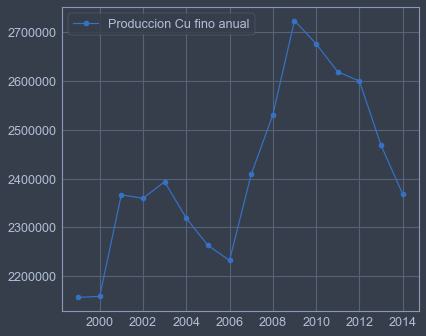

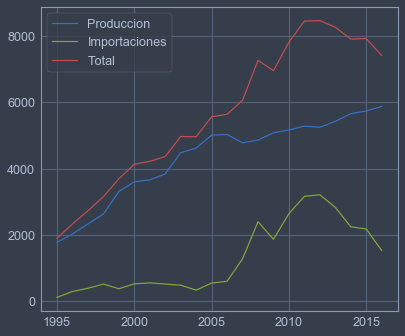

In [8]:
# fig, ax = plt.subplot()
figura, axe = plt.subplots(nrows=1, ncols=1)
produccion_fino.plot(style='bo-', ax=axe, grid=True)

figura, axe = plt.subplots(nrows=1, ncols=1)
consumo_acido.plot(ax=axe, grid=True)
plt.show()

In [47]:
# multitask gaussian process
# datos de fino como matrices
t_cu_fino = produccion_fino.index.values
t_cu_fino = np.reshape(t_cu_fino,newshape=(t_cu_fino.shape[0],1))
prod_fino = produccion_fino.as_matrix()

# datos de acido como matrices
t_ac = consumo_acido.index.values
t_ac = np.reshape(t_ac, newshape=(t_ac.shape[0],1))
prod_ac = consumo_acido.Produccion.as_matrix()
prod_ac = np.reshape(prod_ac, newshape=(prod_ac.shape[0],1))
consumo_ac = consumo_acido.Total.as_matrix()
# imp_ac = consumo_acido.Importaciones.as_matrix()

# datos de ley como matrices
t_leyes = df_leyes.year.as_matrix()
t_leyes = np.reshape(t_leyes, newshape=(t_leyes.shape[0],1))
leyes = df_leyes.ley.as_matrix()
leyes = np.reshape(leyes, newshape=(leyes.shape[0],1))

(22, 1)

In [54]:
# definicion del kernel
K = GPy.kern.RBF(1)
icm = GPy.util.multioutput.ICM(input_dim=1, num_outputs=2, kernel=K)
modelo = GPy.models.GPCoregionalizedRegression([t_ac,t_leyes],[prod_ac, leyes])
modelo.optimize()

In [55]:
# graficar resultados
plot_2outputs(modelo)

TypeError: plot_2outputs() missing 2 required positional arguments: 'xlim' and 'ylim'